In [14]:
#Importing required Lbraries
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,7

In [15]:
#Loading dataset
amazon=web.DataReader('AMZN',data_source='yahoo',start='4/6/2016',end='4/6/2018',)
amazon.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-04-06,602.390015,587.500000,587.520020,602.080017,2833500,602.080017
2016-04-07,599.599976,589.080017,598.760010,591.429993,3189000,591.429993
2016-04-08,597.859985,589.000000,594.320007,594.599976,2591900,594.599976
2016-04-11,604.000000,594.909973,596.140015,595.929993,2704300,595.929993
2016-04-12,604.059998,592.309998,598.400024,603.169983,2636300,603.169983


In [29]:
amazon.drop(columns=['High','Low','Close','Volume','Adj Close'],axis=1,inplace=True)

In [30]:
#inspecting table
amazon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2016-04-06 to 2018-04-06
Data columns (total 1 columns):
Open    505 non-null float64
dtypes: float64(1)
memory usage: 7.9 KB


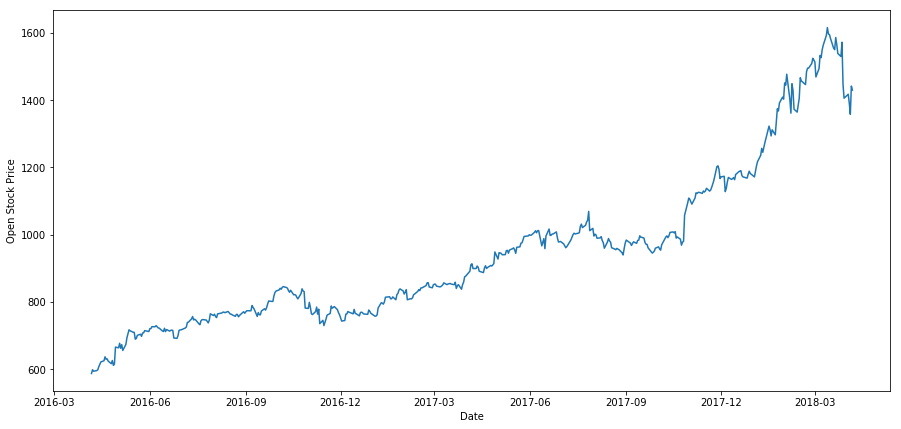

In [31]:
#plotting Open
plt.xlabel('Date')
plt.ylabel('Open Stock Price')
plt.plot(amazon)

In [106]:
#Checking rolling statistics 
rollmean=amazon.rolling(window=12).mean()
rollstd=amazon.rolling(window=12).std()

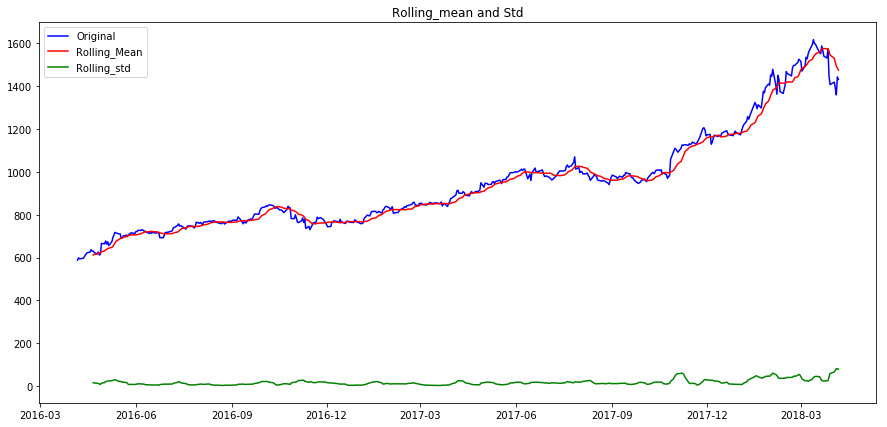

In [33]:
#plottin rolling data
original=plt.plot(amazon,color='blue',label='Original')
rollig_mean=plt.plot(rollmean,color='red',label='Rolling_Mean')
std=plt.plot(rollstd,color='green',label='Rolling_std')
plt.legend(loc='best')
plt.title('Rolling_mean and Std')
plt.show()

In [35]:
#Using Adfuller test to check for stationarity  of data
from statsmodels.tsa.stattools import adfuller
adfuller_test=adfuller(amazon['Open'])

adfuller_results = pd.Series(adfuller_test[0:4],index=['Statistics','P-value','lags used','Observations_used'])
print(adfuller_results)

Statistics            -0.054909
P-value                0.953749
lags used              3.000000
Observations_used    501.000000
dtype: float64


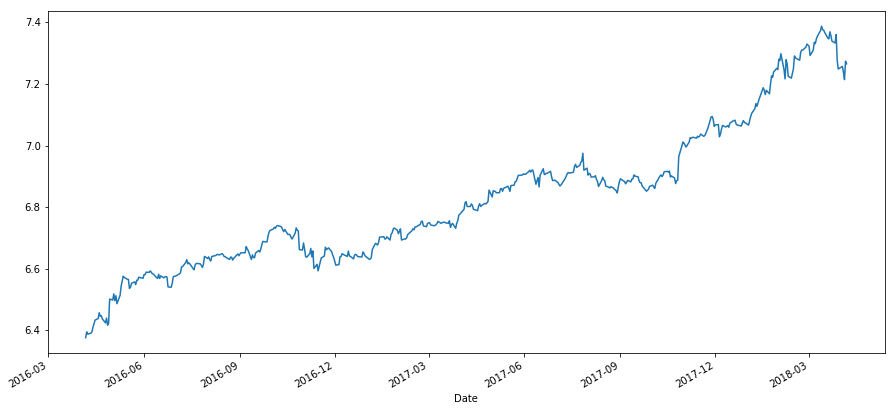

In [36]:
# As observed the P value is very high so we can not reject null hypothesis implying data is not stationary.
#Trend Estimation
amazon_log=np.log(amazon['Open'])
amazon_log.plot()

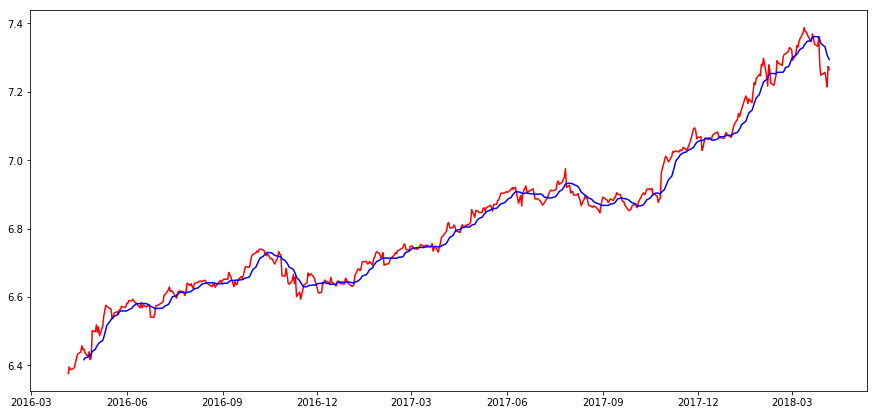

In [37]:
MovingAverage=amazon_log.rolling(window=12).mean()
Movingstd=amazon_log.rolling(window=12).std()
figure=plt.figure()
plt.plot(amazon_log,color='red')
plt.plot(MovingAverage,color='blue')
plt.show()

In [38]:
#We create a function for stationarity test
from statsmodels.tsa.stattools import adfuller
def stationarity_test(timeseries):
    movingAv=timeseries.rolling(window=12).mean()
    movingstd=timeseries.rolling(window=12).std()
 
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(movingAv, color='red', label='Rolling Mean')
    std  = plt.plot(movingstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print (dfoutput)
    

In [42]:
#Time Series Transformation
log_minus_average=amazon_log-MovingAverage
log_minus_average.dropna(inplace=True)
log_minus_average.head()

Date
2016-04-21    0.031019
2016-04-22    0.015533
2016-04-25    0.000419
2016-04-26    0.011454
2016-04-27   -0.013924
Name: Open, dtype: float64

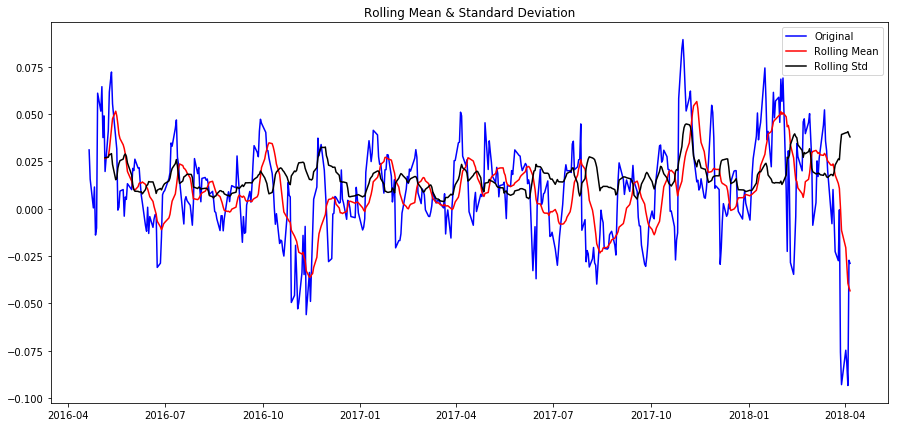

Results of Dickey-Fuller Test:
Test Statistic                -6.603525e+00
p-value                        6.643935e-09
#Lags Used                     0.000000e+00
Number of Observations Used    4.930000e+02
dtype: float64


In [43]:
stationarity_test(log_minus_average)
#From the results (p value <<< 0.05 ) we can now agree our model is stationary

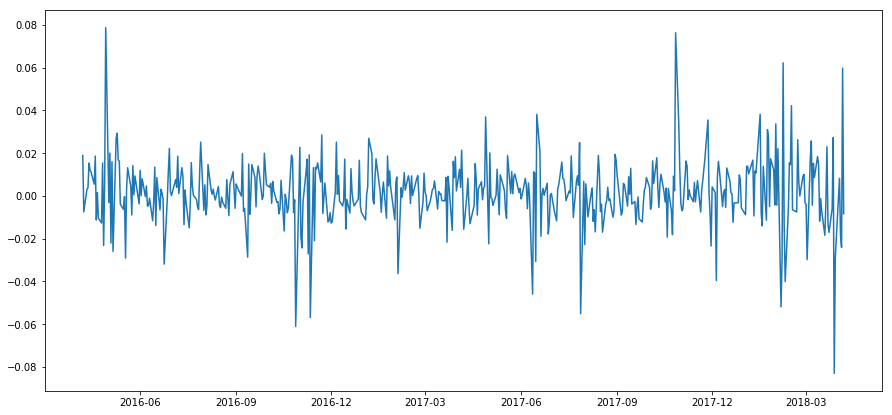

In [56]:
amazon_log_shift=amazon_log-amazon_log.shift()
plt.plot(amazon_log_shift)

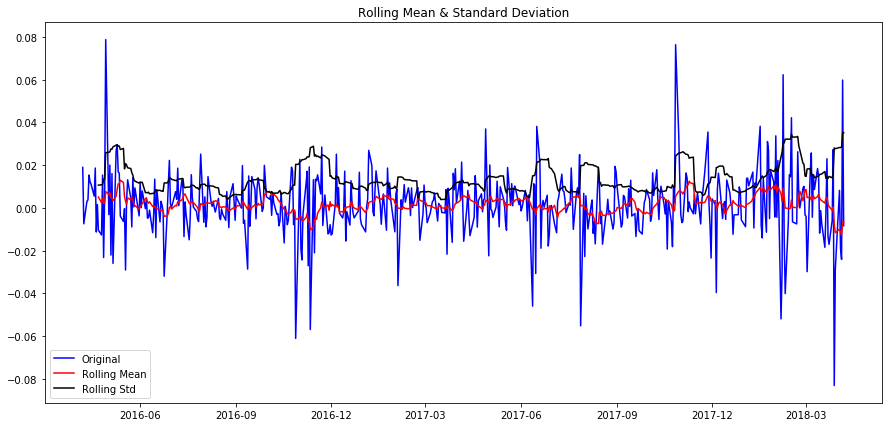

Results of Dickey-Fuller Test:
Test Statistic                -1.702623e+01
p-value                        8.387836e-30
#Lags Used                     1.000000e+00
Number of Observations Used    5.020000e+02
dtype: float64


In [57]:
amazon_log_shift.dropna(inplace=True)
stationarity_test(amazon_log_shift)

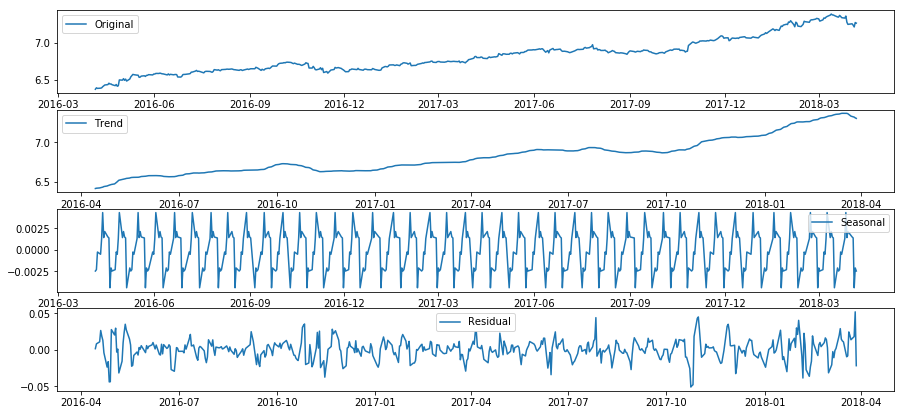

In [64]:
#Components of Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(amazon_log,freq=12)

trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

plt.subplot(411)
plt.plot(amazon_log,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')


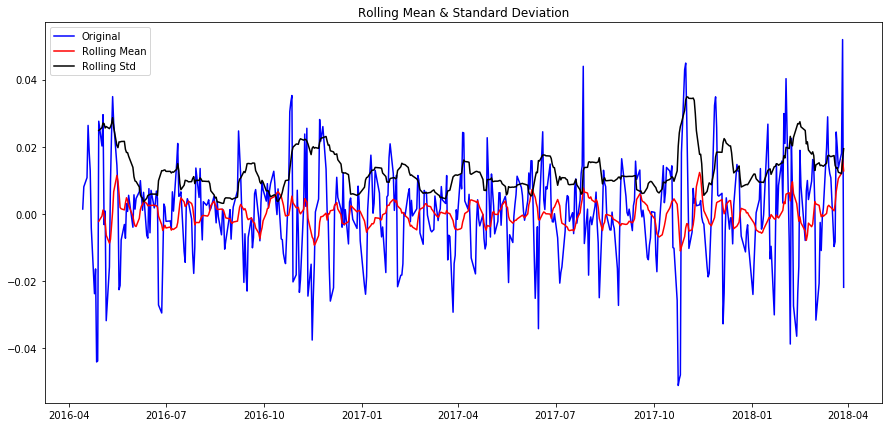

Results of Dickey-Fuller Test:
Test Statistic                -9.388586e+00
p-value                        6.655152e-16
#Lags Used                     1.300000e+01
Number of Observations Used    4.790000e+02
dtype: float64


In [67]:
#Analysing residuals or noise
amazon_decomposed_residuals=residual
amazon_decomposed_residuals.dropna(inplace=True)
stationarity_test(amazon_decomposed_residuals)

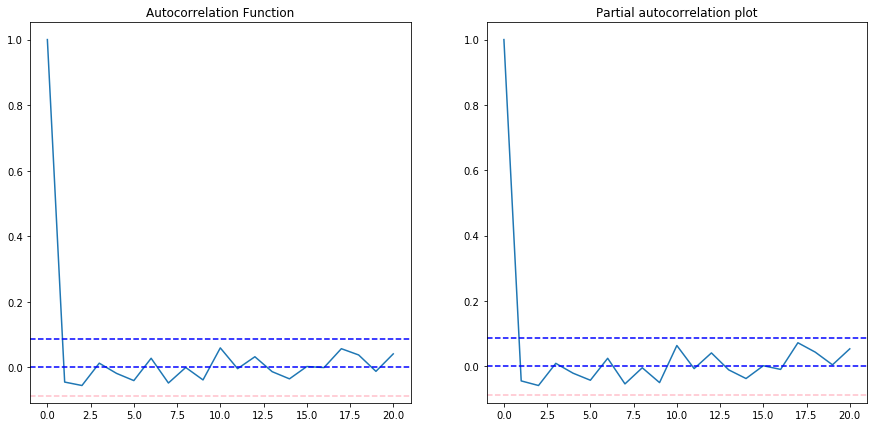

In [70]:
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(amazon_log_shift,nlags=20)
lag_pacf = pacf(amazon_log_shift,nlags=20,method='ols')

#ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(amazon_log_shift)),linestyle='--',color='pink')
plt.axhline(y=1.96/np.sqrt(len(amazon_log_shift)),linestyle='--',color='blue')
plt.title('Autocorrelation Function')

#PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(amazon_log_shift)),linestyle='--',color='pink')
plt.axhline(y=1.96/np.sqrt(len(amazon_log_shift)),linestyle='--',color='blue')
plt.title('Partial autocorrelation plot')
plt.show()

/home/jason/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/jason/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


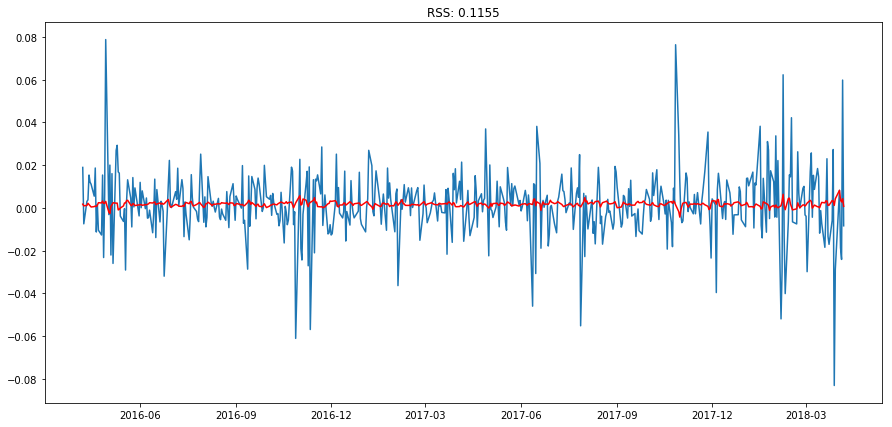

In [86]:
from statsmodels.tsa.arima_model import ARIMA

#ARIMA MODEL
model = ARIMA(amazon_log,order=(2,1,2))
result_ARIMA = model.fit(disp=-1)
plt.plot(amazon_log_shift)
plt.plot(result_MA.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((result_ARIMA.fittedvalues-amazon_log_shift)**2))
plt.show()

/home/jason/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/jason/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5,1,'RSS: 0.1156')

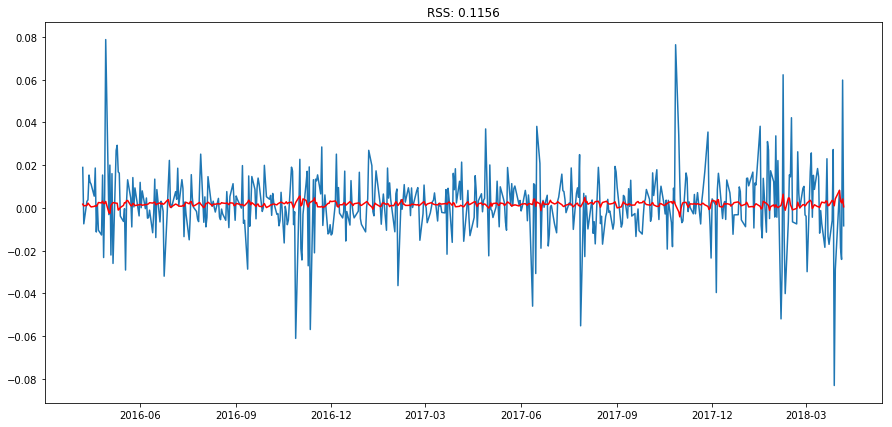

In [83]:
#AR MODEL
model = ARIMA(amazon_log,order=(2,1,0))
result_AR = model.fit(disp=-1)
plt.plot(amazon_log_shift)
plt.plot(result_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((result_AR.fittedvalues-amazon_log_shift)**2))

/home/jason/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/jason/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5,1,'RSS: 0.1156')

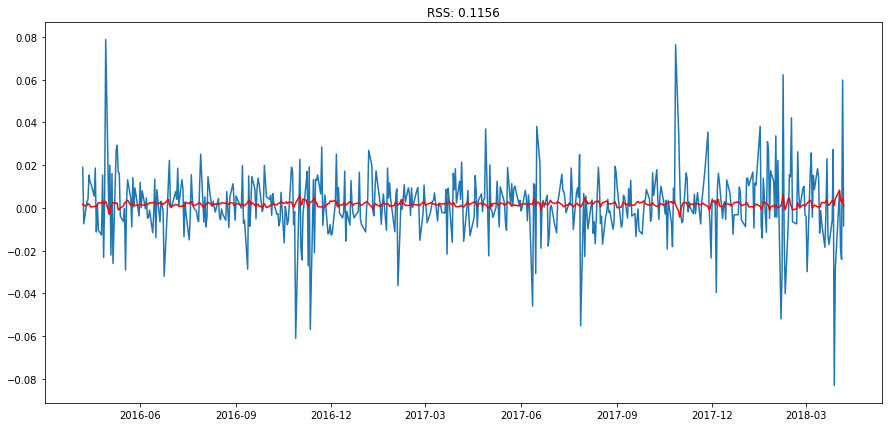

In [85]:
#MA MODEL
model = ARIMA(amazon_log,order=(0,1,2))
result_MA = model.fit(disp=-1)
plt.plot(amazon_log_shift)
plt.plot(result_MA.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((result_MA.fittedvalues-amazon_log_shift)**2))

In [89]:
predictions_ARIMA_diff=pd.Series(result_ARIMA.fittedvalues,copy=True)
print(predictions_ARIMA_diff.head())

Date
2016-04-07    0.001758
2016-04-08    0.001074
2016-04-11    0.001196
2016-04-12    0.001846
2016-04-13    0.001447
dtype: float64


In [90]:
#cumm sum
predictions_ARIMA_diff_cummsum=predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cummsum.head())

Date
2016-04-07    0.001758
2016-04-08    0.002832
2016-04-11    0.004028
2016-04-12    0.005874
2016-04-13    0.007321
dtype: float64


In [92]:
predictions_ARIMA_log=pd.Series(amazon_log,index=amazon_log.index)
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cummsum)
predictions_ARIMA_log.head()

Date
2016-04-06         NaN
2016-04-07    6.396619
2016-04-08    6.390250
2016-04-11    6.394503
2016-04-12    6.400133
dtype: float64

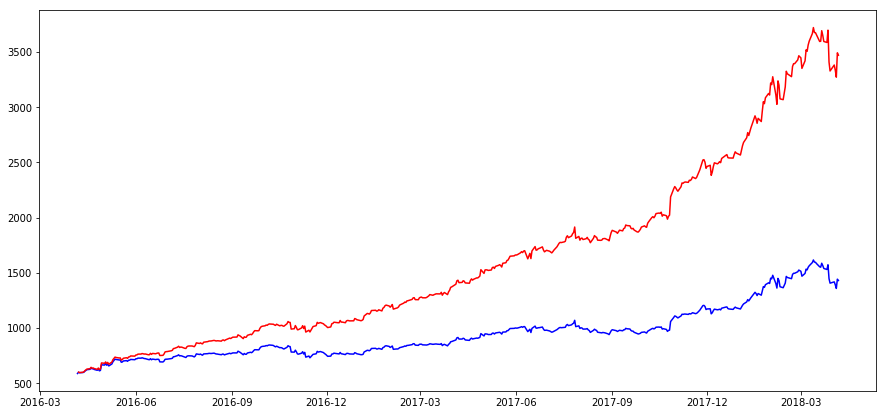

In [94]:
predictions_ARIMA=np.exp(predictions_ARIMA_log)
plt.plot(amazon,color='blue')
plt.plot(predictions_ARIMA,color='red')

In [96]:
amazon.shape

(505, 1)

In [103]:
ending=amazon.shape[0]+ 12*10

/home/jason/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/jason/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/jason/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


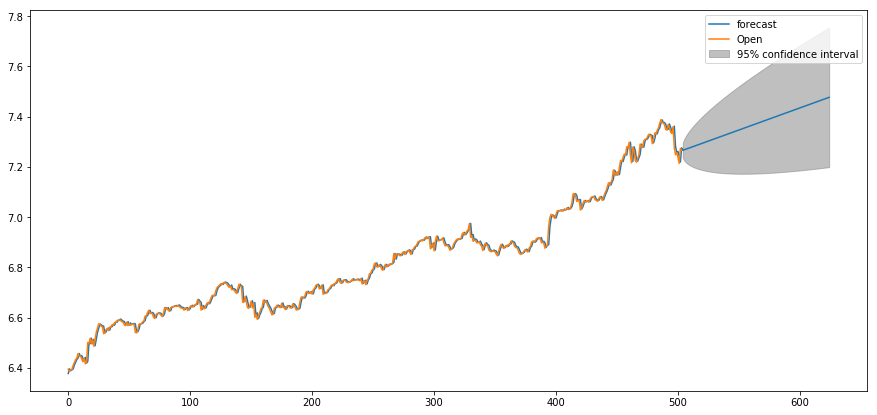

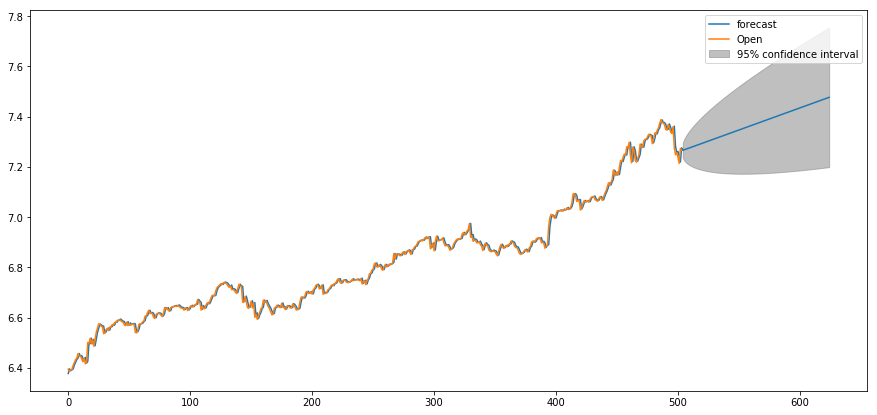

In [104]:
result_ARIMA.plot_predict(start=1,end=ending)

In [112]:
results=result_ARIMA.forecast(steps=120)
results[:1]

(array([7.26587461, 7.26806772, 7.26954733, 7.27138208, 7.27307778,
        7.27484748, 7.27659068, 7.27834962, 7.28010371, 7.28186125,
        7.28361798, 7.28537549, 7.2871329 , 7.28889049, 7.29064808,
        7.29240572, 7.29416336, 7.29592102, 7.29767867, 7.29943634,
        7.301194  , 7.30295166, 7.30470933, 7.30646699, 7.30822466,
        7.30998232, 7.31173999, 7.31349765, 7.31525532, 7.31701298,
        7.31877065, 7.32052831, 7.32228598, 7.32404364, 7.32580131,
        7.32755897, 7.32931664, 7.33107431, 7.33283197, 7.33458964,
        7.3363473 , 7.33810497, 7.33986263, 7.3416203 , 7.34337796,
        7.34513563, 7.34689329, 7.34865096, 7.35040862, 7.35216629,
        7.35392395, 7.35568162, 7.35743928, 7.35919695, 7.36095462,
        7.36271228, 7.36446995, 7.36622761, 7.36798528, 7.36974294,
        7.37150061, 7.37325827, 7.37501594, 7.3767736 , 7.37853127,
        7.38028893, 7.3820466 , 7.38380426, 7.38556193, 7.38731959,
        7.38907726, 7.39083493, 7.39259259, 7.39